Find Players with low potentials but high actual Rating
- Label Players has a potential higher than 83 but never reaches this potential

In [1]:
HYPERTRAINING = False
CV = 5
SCORING = 'r2'
AUTO_FEATURE_SELECT = 'backward'
# forward eher schlecht
#'neg_mean_squared_error'   nope
#r2 sehr gut -> 0.45
# 'explained_variance'
# HUBER
if SCORING in ['neg_mean_squared_error']:
    DIRECTION = "minimize"
else:
    DIRECTION = "maximize"
TRIALS = 30    
EXPERIEMENT_NAME = "offense_potential_winger"
SAVE_MODEL_NAME = EXPERIEMENT_NAME
CLASS_WEIGHTS = 'balanced'

RUN_NAME = None
TARGET_OVERALL = 78

PLAYER_ATTRIBUTES = [ 'central','winger','offense','Finishing',  'ShortPassing', 'Volleys', 'Dribbling',  'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility',    'Reactions', 'Balance', 
                      'ShotPower', 'Jumping',  'LongShots', 'Positioning', 'Vision' ]
# PLAYER_ATTRIBUTES = [ 'Age' ,'Dribbling',  'FKAccuracy',  'BallControl','ShotPower','Positioning', 'Penalties' ]
PLAYER_ATTRIBUTES = [  'central','offense','Age','Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy', 'LongPassing', 'BallControl',
                      'Acceleration', 'SprintSpeed', 'Agility', 'GKPositioning', 'GKReflexes', 'Composure', 'Defensive awareness', 'Reactions', 'Balance', 
                      'ShotPower', 'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Marking', 
                      'StandingTackleshooting_technique', 'SlidingTackle', 'GKDiving', 'GKHandling', 'GKKicking']
PLAYER_ATTRIBUTES = ['Reactions', 'age_based_Stamina', 'Positioning', 'ShortPassing',  'Dribbling', 'BallControl',    'Aggression',   'Vision',  'SprintSpeed','shooting']
PLAYER_ATTRIBUTES = ['Crossing', 'Finishing','shooting_technique','mental',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression',  'Positioning', 'Vision',
       'Penalties',  
        'youth_player', 'shooting', 
       'mental', 'physique', 'Speed', 'ball_handling', 'age_based_Reactions',
       'age_based_physique', 'age_based_shooting_technique',
       'age_based_Stamina', 'age_based_Positioning', 'age_based_Vision',
       'age_based_Finishing', 'age_based_BallControl']

PLAYER_ATTRIBUTES = [ 'Finishing',
       'ShortPassing', 'Dribbling',  'FKAccuracy',
       'BallControl',  'SprintSpeed', 'Agility',
       'Reactions', 'Balance',  
       'Positioning'        ]


In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os

def find_and_append_module_path():
    current_dir = os.getcwd()
    substring_to_find = 'statsfaction'
    index = current_dir.rfind(substring_to_find)
    
    if index != -1:
        # Extract the directory path up to and including the last "mypath" occurrence
        new_dir = current_dir[:index + (len(substring_to_find))]

        # Change the current working directory to the new directory
        os.chdir(new_dir)
        sys.path.append(new_dir)
        # Verify the new current directory
        print("New current directory:", os.getcwd())
    else:
        print("No 'mypath' found in the current directory")

find_and_append_module_path()

import os
import warnings
from datetime import datetime
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, HuberRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, classification_report

import mlflow
import mlflow.sklearn
import mlflow.xgboost
import mlflow.lightgbm

from prediction_prime_overall.src.prepare import (
    add_features_raw,
    select_features
)
from prediction_prime_overall.src.eval import (
    plot_feature_importance,
    plot_shap_summary,
    plot_auc_curves,
    log_metrics_in_mlflow_regression,
    log_metrics_in_mlflow,
    log_feature_list_as_artifact
)
import prediction_prime_overall.config as CONFIG
from prediction_prime_overall.src.utils import *


mlflow.set_tracking_uri("file:///"+CONFIG.MLFLOW)
mlflow.set_experiment(EXPERIEMENT_NAME)


New current directory: c:\Users\Robert\Documents\Projekte\statsfaction


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
2023/12/08 21:15:53 INFO mlflow.tracking.fluent: Experiment with name 'offense_potential_winger' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:\\Users\\Robert\\Documents\\Projekte\\statsfaction\\prediction_prime_overall\\data\\mlflow/922108928261947764', creation_time=1702066553535, experiment_id='922108928261947764', last_update_time=1702066553535, lifecycle_stage='active', name='offense_potential_winger', tags={}>

### Get Data

In [3]:
sql_prime = """
SELECT max(Age) as prime_age,* FROM(SELECT MAX(Overall) AS PrimeOverall,*
  FROM fifa
  GROUP BY ID ) 
  GROUP BY ID
  order by PrimeOverall DESC;
"""

sql_potentials = f"""
SELECT min(Age) as potential_age,* FROM  (SELECT *,Potential as max_potential FROM fifa WHERE Potential>={TARGET_OVERALL})
GROUP BY ID
order by potential DESC;
"""



In [4]:


# Step 1: Establish a database connection
conn = sqlite3.connect(CONFIG.DATABASE)

df_potentials = pd.read_sql_query(sql_potentials, conn)
df_prime = pd.read_sql_query(sql_prime, conn)

conn.close()

df_potentials = df_potentials.set_index(['ID'])
df_prime = df_prime.set_index(['ID'])

df_raw = df_potentials.join(df_prime[["prime_age","PrimeOverall"]])
df_raw = df_raw.reset_index(['ID'])
df_raw = add_features_raw(df_raw)

df_raw.head()


,,,potential_age,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,Value,...,Composure,Defensive awareness,max_potential,prime_age,PrimeOverall,best_position,central,winger,offense,Defense
ID,Name,FIFA,,,,,,,,,,,,,,,,,,,,,
158023,L. Messi,2011,23.0,23.0,https://cdn.sofifa.net/players/158/023/11_60.png,Argentina,https://cdn.sofifa.net/flags/ar.png,90.0,95.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€0,...,NaN,NaN,95.0,25.0,94.0,RW,0,1,1.0,13.0
20801,Cristiano Ronaldo,2011,25.0,25.0,https://cdn.sofifa.net/players/020/801/11_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,89.0,94.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€0,...,NaN,NaN,94.0,31.0,94.0,RW,0,1,1.0,22.0
244778,Trincão,2021,20.0,20.0,https://cdn.sofifa.net/players/244/778/21_60.png,Portugal,https://cdn.sofifa.net/flags/pt.png,78.0,91.0,FC Barcelona,https://cdn.sofifa.net/meta/team/83/30.png,€34M,...,84.0,35.0,91.0,20.0,78.0,RW,0,1,1.0,35.0
183277,E. Hazard,2011,19.0,19.0,https://cdn.sofifa.net/players/183/277/11_60.png,Belgium,https://cdn.sofifa.net/flags/be.png,81.0,91.0,LOSC Lille,https://cdn.sofifa.net/meta/team/690/30.png,€0,...,NaN,NaN,91.0,27.0,91.0,RW,0,1,1.0,35.0
243812,Rodrygo,2021,19.0,19.0,https://cdn.sofifa.net/players/243/812/21_60.png,Brazil,https://cdn.sofifa.net/flags/br.png,79.0,90.0,Real Madrid,https://cdn.sofifa.net/meta/team/3468/30.png,€38M,...,82.0,25.0,90.0,21.0,81.0,RW,0,1,1.0,25.0


# 

In [5]:
# df_raw["Potential"] = df_raw.Potential.astype('float')
# df_raw["max_potential"] = df_raw.max_potential.astype('float')

In [6]:
df = df_raw.copy()

year_to_category = {2011: 'drop', 2012: 'train', 2013: 'train', 2014: 'train', 2015: 'train', 2016: 'train', 2017: 'train', 2018: 'train', 2019: 'train', 2020: 'test', 2021: 'test', 2022: 'valid', 2023: 'valid', 2024: 'valid'}
df['set'] = df.index.get_level_values('FIFA').values
# Apply the mapping to the "FIFA" column
df['set'] = df['set'].map(year_to_category)

df_potentials = df[(df.set=="valid")&(df.Age<26)&(df.Potential>=TARGET_OVERALL)]

In [7]:
df = df[(df.winger == 1)&(df.offense > 0.5)]

# Training nur auf High Potentials
df = df[df.max_potential>TARGET_OVERALL]

# nur Entwicklugnsfähige Spieler
df = df[df.prime_age>df.potential_age]
df = df[df.PrimeOverall>df.Overall]
df['target'] = df.PrimeOverall
df = df[df.potential_age<23]

print(df.target.value_counts())
PREDICTION_NAME = "Offense"

df_processed = df.copy()

target
77.0    27
71.0    22
74.0    20
76.0    18
69.0    17
79.0    16
72.0    16
75.0    16
68.0    16
73.0    15
78.0    15
67.0    14
70.0     8
84.0     8
65.0     7
81.0     7
82.0     7
85.0     5
80.0     5
83.0     5
64.0     4
66.0     4
87.0     3
88.0     2
86.0     2
91.0     2
89.0     2
63.0     1
60.0     1
92.0     1
58.0     1
90.0     1
Name: count, dtype: int64


In [8]:
df[["potential_age","Age","prime_age","max_potential","Potential","Overall","PrimeOverall","target","set","best_position"]].head()

,,,potential_age,Age,prime_age,max_potential,Potential,Overall,PrimeOverall,target,set,best_position
ID,Name,FIFA,,,,,,,,,,
183277,E. Hazard,2011,19.0,19.0,27.0,91.0,91.0,81.0,91.0,91.0,drop,RW
243812,Rodrygo,2021,19.0,19.0,21.0,90.0,90.0,79.0,81.0,81.0,test,RW
208790,Z. Bakkali,2014,17.0,17.0,20.0,90.0,90.0,73.0,74.0,74.0,train,RW
255475,Antony,2021,20.0,20.0,22.0,88.0,88.0,78.0,82.0,82.0,test,RW
246045,P. De la Vega,2020,18.0,18.0,22.0,88.0,88.0,70.0,75.0,75.0,test,RW


In [9]:
# if True:
#     df = df[[any(pos in i for pos in ['CF', 'LW', 'ST', 'RW']) for i in df['Position']]]
#     df.shape
# else:
#     select_position = lambda x: x in ["ST","CF","LW","RW"]
#     df["select"] = df['Position'].apply(select_position)
#     df = df[df["select"]]
#     df.shape

###  Feature Engineering

In [10]:
df_processed.columns[df_processed.isna().sum()>0]

Index(['Club', 'Marking', 'Att. Position', 'Composure', 'Defensive awareness'], dtype='object')

#### Transform Value

In [11]:
df_processed = df_processed.fillna(0)
df_potentials = df_potentials.fillna(0)

<Axes: >

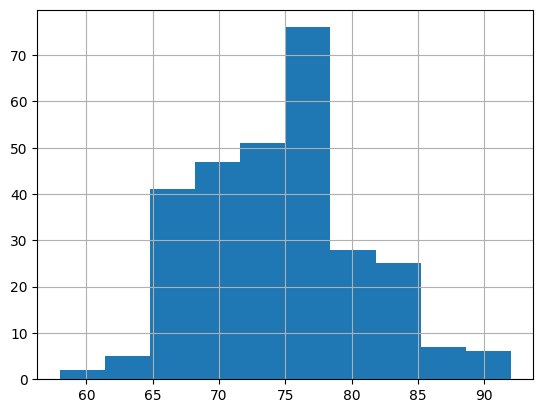

In [12]:
df['target'].hist()

In [13]:
X = df_processed.drop("target", axis=1, errors='ignore')
y = df['target']  # Use df_processed here instead of df
# Split the data into training and testing sets

In [14]:
df_processed.columns

Index(['potential_age', 'Age', 'Photo', 'Nationality', 'Flag', 'Overall',
       'Potential', 'Club', 'Club Logo', 'Value', 'Wage', 'Special',
       'Position', 'Unnamed: 0', 'Crossing', 'Finishing', 'HeadingAccuracy',
       'ShortPassing', 'Volleys', 'Dribbling', 'Curve', 'FKAccuracy',
       'LongPassing', 'BallControl', 'Acceleration', 'SprintSpeed', 'Agility',
       'Reactions', 'Balance', 'ShotPower', 'Jumping', 'Stamina', 'Strength',
       'LongShots', 'Aggression', 'Interceptions', 'Positioning', 'Vision',
       'Penalties', 'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving',
       'GKHandling', 'GKKicking', 'GKPositioning', 'GKReflexes',
       'Att. Position', 'Composure', 'Defensive awareness', 'max_potential',
       'prime_age', 'PrimeOverall', 'best_position', 'central', 'winger',
       'offense', 'Defense', 'set', 'target'],
      dtype='object')

In [15]:
if False:
    # Step 1: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train = X_train[PLAYER_ATTRIBUTES]
    X_test = X_test[PLAYER_ATTRIBUTES]

else:

    X_train = X[X.set=="train"][PLAYER_ATTRIBUTES]
    y_train = y[X.set=="train"]

    X_test = X[X.set=="test"][PLAYER_ATTRIBUTES]
    y_test = y[X.set=="test"]


In [16]:
y_train.describe()

count    137.000000
mean      75.817518
std        5.611463
min       63.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       92.000000
Name: target, dtype: float64

In [17]:


# Ignore all warnings
warnings.filterwarnings("ignore")
# Load your dataset or replace df_processed and df with your data
# df_processed = pd.read_csv('your_dataset.csv')


# Step 2: Initialize a StandardScaler
scaler = StandardScaler()

# Step 3: Fit the scaler on the training data and transform both training 
# and testing data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

df_potentials_scaled = scaler.transform(df_potentials[PLAYER_ATTRIBUTES].fillna(0))

# Step 4: Create new DataFrames with the scaled data while preserving the index and columns
X_train_scaled_df = pd.DataFrame(X_train_scaled, index=X_train.index, columns=PLAYER_ATTRIBUTES)
X_test_scaled_df = pd.DataFrame(X_test_scaled, index=X_test.index, columns=PLAYER_ATTRIBUTES)
df_potentials_scaled_df = pd.DataFrame(df_potentials_scaled, index=df_potentials.index, columns=PLAYER_ATTRIBUTES)

# Hyperparametertuning

In [18]:
import optuna
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.2, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(RandomForestRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RF = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RF)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RF = {}


In [19]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 1, 8),
            'min_samples_split': trial.suggest_float('min_samples_split', 0.1, 1.0),
            'min_samples_leaf': trial.suggest_float('min_samples_leaf', 0.1, 0.5),
            'max_features': trial.suggest_float('max_features', 0.6, 1.0),
            'random_state': 42
        }

        # Implement cross-validation
        cv_scores = cross_val_score(GradientBoostingRegressor(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_GB = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_GB)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_GB = {}


In [20]:
import optuna
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, KFold

if HYPERTRAINING:
    def objective(trial):
        # Define hyperparameters to optimize
        params = {
            'alpha': trial.suggest_float('alpha', 0.01, 10.0),
            'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
        }

        # Implement cross-validation
        cv_scores = cross_val_score(Ridge(**params), X_train_scaled_df, y_train, cv=CV, scoring=SCORING)
        mean_mse = cv_scores.mean()  # Note the negative sign for mean_squared_error

        return mean_mse

    # Create an Optuna study for minimizing Mean Squared Error
    study = optuna.create_study(direction=DIRECTION)
    study.optimize(objective, n_trials=TRIALS)  # You can increase n_trials for more optimization

    PARAMS_RIDGE = study.best_params
    best_mse = study.best_value  # Note the negative sign for mean_squared_error

    print("Best hyperparameters:", PARAMS_RIDGE)
    print(f"Best Mean {SCORING}:", best_mse)
else:
    PARAMS_RIDGE = {}


# TODOS
- SHAP Values for Regression Models -> DONE
- SCV and Logistic Regression -> nope
- Hyperparameter Tuning -> nope
- classification model einbauen -> DONE
- Make Usable in Deployment  -> DONE
- Finishing + FKAccuaracy -> Shooting
- Blog umschreiben
- Video machen :)

Ridge Regression training----->


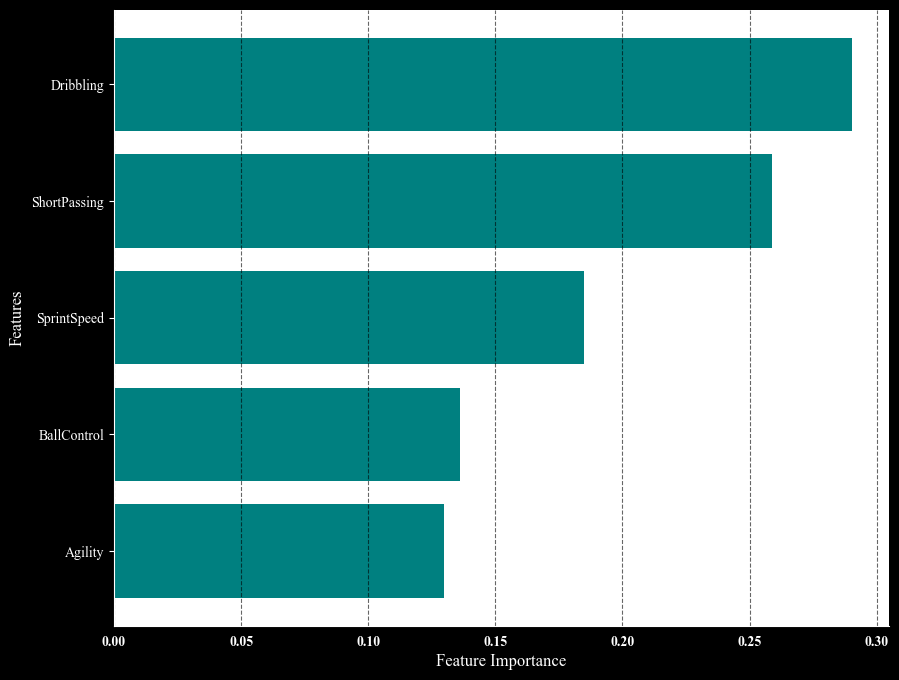

100%|██████████| 30/30 [00:02<00:00, 14.78it/s]


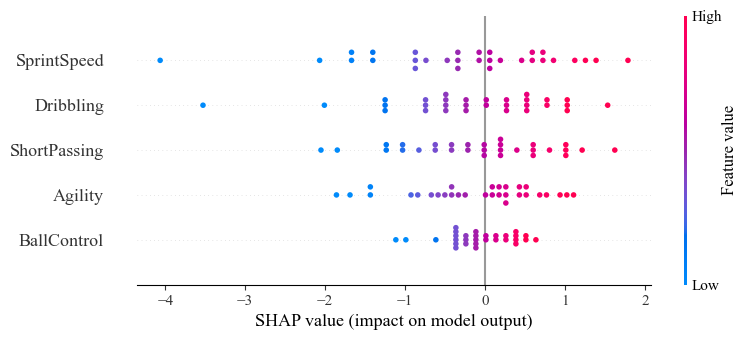

              precision    recall  f1-score   support

       False       0.94      0.94      0.94        47
        True       0.50      0.50      0.50         6

    accuracy                           0.89        53
   macro avg       0.72      0.72      0.72        53
weighted avg       0.89      0.89      0.89        53

Huber Regression training----->


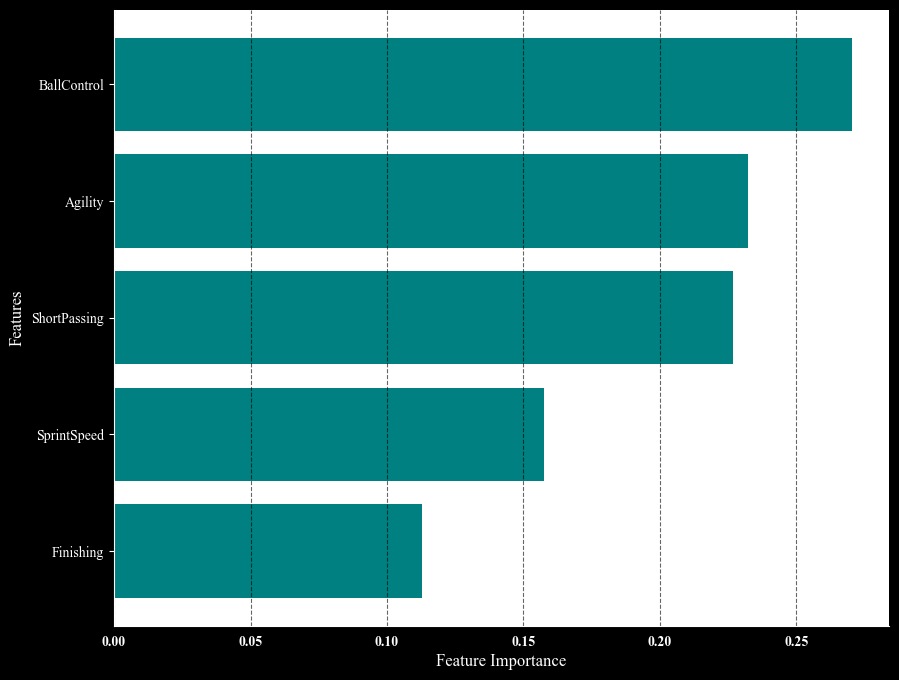

100%|██████████| 30/30 [00:01<00:00, 28.00it/s]


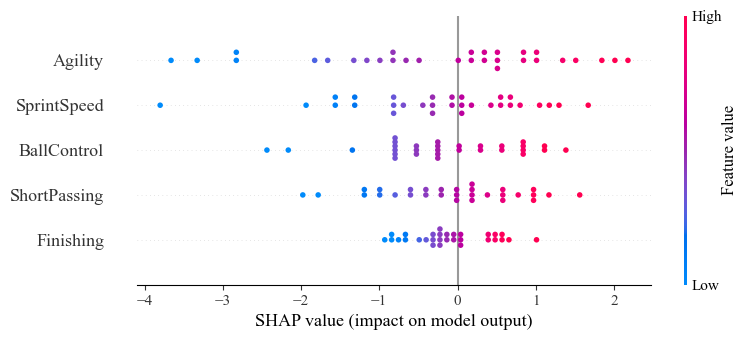

              precision    recall  f1-score   support

       False       0.93      0.89      0.91        47
        True       0.38      0.50      0.43         6

    accuracy                           0.85        53
   macro avg       0.65      0.70      0.67        53
weighted avg       0.87      0.85      0.86        53

Linear Regression training----->


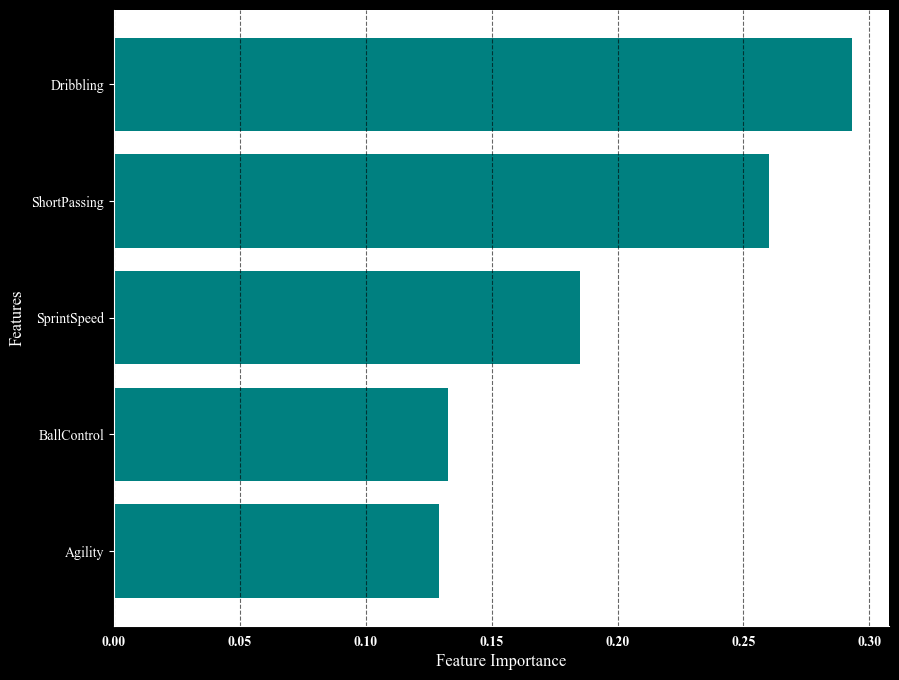

100%|██████████| 30/30 [00:01<00:00, 18.40it/s]


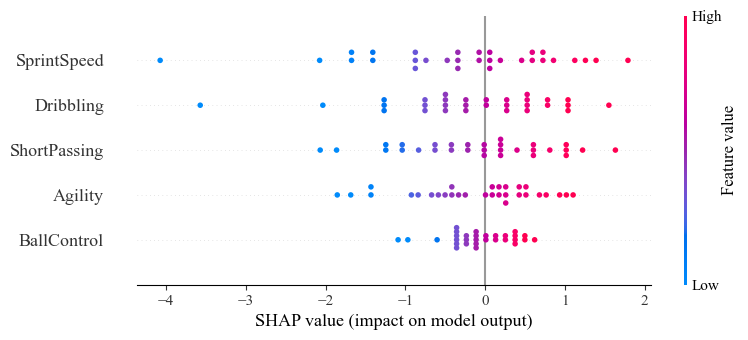

              precision    recall  f1-score   support

       False       0.94      0.94      0.94        47
        True       0.50      0.50      0.50         6

    accuracy                           0.89        53
   macro avg       0.72      0.72      0.72        53
weighted avg       0.89      0.89      0.89        53

Model: Ridge Regression
Mean Squared Error: 20.10
Mean Absolute Error: 3.70
R2 Score: 0.32

Model: Huber Regression
Mean Squared Error: 20.82
Mean Absolute Error: 3.78
R2 Score: 0.29

Model: Linear Regression
Mean Squared Error: 20.09
Mean Absolute Error: 3.70
R2 Score: 0.32



In [21]:



regression_models = {
    'Ridge Regression': Ridge(**PARAMS_RIDGE),
    'Huber Regression':HuberRegressor(),
    # 'AdaBoost Regressor': AdaBoostRegressor(random_state=42),

    # 'Lasso Regression': Lasso(),
    # 'ElasticNet Regression': ElasticNet(),
    'Linear Regression': LinearRegression(),
    # 'Random Forest Regressor': RandomForestRegressor(**PARAMS_RF,random_state=42),
    # 'Gradient Boosting Regressor': GradientBoostingRegressor(**PARAMS_GB,random_state=42),
    # 'XGBoost Regressor': xgb.XGBRegressor(random_state=42),
    # 'LightGBM Regressor': lgb.LGBMRegressor(random_state=42)
    # Add more models as needed
}


regression_results = {}

# Set the experiment name

# Start MLflow run with a specific run name and description
for model_name, model in regression_models.items():

    # Get the current timestamp
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    with mlflow.start_run(run_name=f"{model_name}_{timestamp}"):

        print(model_name, "training----->")

        # Log parameters
        mlflow.log_param("Model_Name", model_name)
        mlflow.log_params(model.get_params())

        features = select_features(method=AUTO_FEATURE_SELECT,X=X_train_scaled_df,y=y_train,model=model)
        
        model.fit(X_train_scaled_df[features], y_train)
        y_pred = model.predict(X_test_scaled_df[features])
        
        # Log Params
        log_feature_list_as_artifact(PLAYER_ATTRIBUTES, filename="feature_list.txt")

        # Create a dictionary with parameters and their values
        params_to_log = {
            'HYPERTRAINING': HYPERTRAINING,
            'CV': CV,
            'SCORING': SCORING,
            'features_anzahl': len(features),
            'TARGET_OVERALL': TARGET_OVERALL
        }

        # Log parameters using log_params
        mlflow.log_params(params_to_log)

        # Log artifacts
        mlflow.sklearn.log_model(model, model_name)

        # Evaluation Metrics
        log_metrics_in_mlflow_regression(y_test=y_test, y_pred=y_pred,X = X_test_scaled_df[features])
        log_metrics_in_mlflow(y_test=y_test>TARGET_OVERALL,y_prob=None,y_pred=y_pred>TARGET_OVERALL)

        # Evaluation Plots (Note: Regression models may not have ROC curves, so adapt this as needed)
        plot_feature_importance(model, '', top_n=20)
        explainer = plot_shap_summary(model=model,df=X_test_scaled_df[features],K = 30)

        # Output for quick evaluation
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        

        report = classification_report(y_test>TARGET_OVERALL, y_pred>TARGET_OVERALL)
        print(report)

     
        regression_results[model_name] = {
            'Model': model,
            'Scaler': scaler,
            'explainer':explainer,
            'attributes': features,
            'Classification Report': report,
            'Mean Squared Error': mse,
            'Mean Absolute Error': mae,
            'R2 Score': r2
        }

# Evaluate and print results for each model
for model_name, results in regression_results.items():
    print(f"Model: {model_name}")
    print(f"Mean Squared Error: {results['Mean Squared Error']:.2f}")
    print(f"Mean Absolute Error: {results['Mean Absolute Error']:.2f}")
    print(f"R2 Score: {results['R2 Score']:.2f}")
    print()




In [22]:

if SAVE_MODEL_NAME!="":
    save_dict_as_pickle(data_dict = regression_results, file_path=f"{CONFIG.MODELS}/{SAVE_MODEL_NAME}.pkl")

# evaluate Model

In [23]:
X_train.describe()

,Finishing,ShortPassing,Dribbling,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,Balance,Positioning
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,63.379562,64.547445,74.364964,53.357664,71.868613,80.766423,78.956204,63.715328,74.065693,64.080292
std,6.910277,6.226096,5.633247,11.670562,5.345170,6.831225,7.510648,8.760665,10.640658,7.193807
min,36.000000,47.000000,57.000000,24.000000,58.000000,63.000000,54.000000,36.000000,26.000000,43.000000
25%,59.000000,60.000000,70.000000,45.000000,68.000000,77.000000,74.000000,58.000000,68.000000,59.000000
50%,64.000000,65.000000,75.000000,54.000000,72.000000,81.000000,79.000000,64.000000,74.000000,65.000000
75%,68.000000,69.000000,78.000000,63.000000,75.000000,86.000000,84.000000,69.000000,81.000000,69.000000
max,84.000000,79.000000,90.000000,76.000000,92.000000,95.000000,95.000000,84.000000,92.000000,88.000000


In [24]:
y_test.describe()

count    53.000000
mean     72.603774
std       5.474906
min      60.000000
25%      68.000000
50%      73.000000
75%      77.000000
max      84.000000
Name: target, dtype: float64

In [25]:
my_model = regression_results['Huber Regression']['Model']
my_features = regression_results['Huber Regression']['attributes']


In [26]:
result_df = pd.Series(my_model.predict(X_test_scaled_df[my_features]),index=X_test_scaled_df.index)
len(result_df)

53

<Axes: >

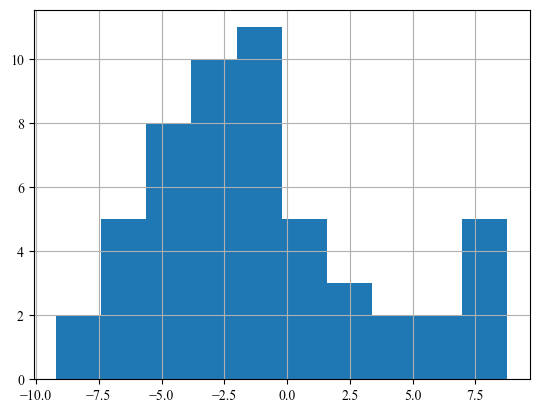

In [27]:
(y_test-result_df).sort_values(ascending=False).hist()

<Axes: >

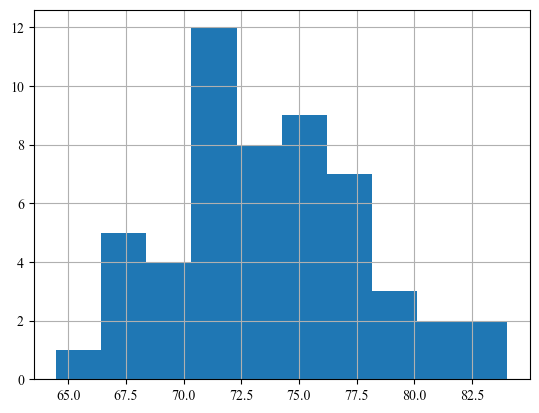

In [28]:
result_df.sort_values(ascending=False).hist()

In [29]:
(y_test-result_df).describe()

count    53.000000
mean     -1.086836
std       4.473930
min      -9.199957
25%      -3.956348
50%      -1.964301
75%       0.959444
max       8.757173
dtype: float64

In [30]:
outlier = (y_test-result_df)>3
X_test[outlier]


,,,Finishing,ShortPassing,Dribbling,FKAccuracy,BallControl,SprintSpeed,Agility,Reactions,Balance,Positioning
ID,Name,FIFA,,,,,,,,,,
246174,H. Elliott,2021,54.0,63.0,72.0,42.0,66.0,72.0,83.0,58.0,80.0,62.0
257279,Alex Baena,2021,59.0,60.0,70.0,58.0,70.0,63.0,58.0,47.0,69.0,65.0
251566,Gabriel Martinelli,2020,62.0,64.0,73.0,49.0,73.0,84.0,76.0,51.0,69.0,62.0
242964,A. Gordon,2021,62.0,62.0,71.0,59.0,68.0,73.0,63.0,59.0,66.0,61.0
240273,E. Smith Rowe,2020,62.0,61.0,68.0,58.0,67.0,79.0,75.0,55.0,68.0,62.0
256516,Nico Williams,2021,66.0,59.0,68.0,57.0,66.0,76.0,69.0,51.0,65.0,62.0
246785,Bryan Gil,2020,60.0,60.0,72.0,52.0,69.0,69.0,77.0,59.0,74.0,60.0
237712,V. Castellanos,2020,68.0,63.0,66.0,35.0,64.0,72.0,70.0,53.0,68.0,63.0
246431,R. Sottil,2021,60.0,60.0,68.0,45.0,68.0,78.0,72.0,58.0,75.0,62.0


In [31]:
y_test[outlier]

ID      Name                FIFA
246174  H. Elliott          2021    77.0
257279  Alex Baena          2021    76.0
251566  Gabriel Martinelli  2020    84.0
242964  A. Gordon           2021    77.0
240273  E. Smith Rowe       2020    78.0
256516  Nico Williams       2021    79.0
246785  Bryan Gil           2020    77.0
237712  V. Castellanos      2020    79.0
246431  R. Sottil           2021    76.0
Name: target, dtype: float64

In [32]:
result_df[outlier]

ID      Name                FIFA
246174  H. Elliott          2021    72.105773
257279  Alex Baena          2021    67.757907
251566  Gabriel Martinelli  2020    75.242827
242964  A. Gordon           2021    69.947689
240273  E. Smith Rowe       2020    72.226542
256516  Nico Williams       2021    70.538856
246785  Bryan Gil           2020    71.489661
237712  V. Castellanos      2020    70.625416
246431  R. Sottil           2021    71.501508
dtype: float64

In [33]:
(y_test/result_df).describe()

count    53.000000
mean      0.985898
std       0.061713
min       0.876011
25%       0.944343
50%       0.973944
75%       1.012454
max       1.121640
dtype: float64

In [34]:
(y_test/result_df).describe()

count    53.000000
mean      0.985898
std       0.061713
min       0.876011
25%       0.944343
50%       0.973944
75%       1.012454
max       1.121640
dtype: float64

In [35]:
np.corrcoef(y_test,result_df)

array([[1.        , 0.60098544],
       [0.60098544, 1.        ]])

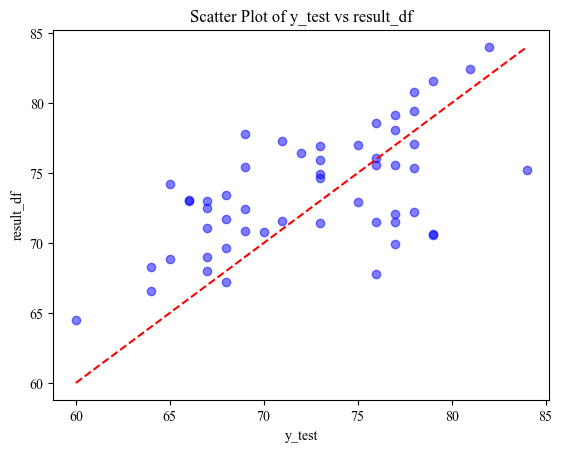

In [36]:

plt.scatter(y_test, result_df, color='blue', alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Diagonal line')

plt.title('Scatter Plot of y_test vs result_df')
plt.xlabel('y_test')
plt.ylabel('result_df')
plt.show()

In [37]:
result_df = result_df.sort_values(ascending=False)

In [38]:
result_df.head(50)

ID      Name                FIFA
255475  Antony              2021    84.012354
243812  Rodrygo             2021    82.418762
253004  Ansu Fati           2021    81.596722
244193  Jovane Cabral       2021    80.819637
243014  B. Mbeumo           2021    79.418399
247181  G. Plata            2021    79.178840
241907  D. Rossi            2020    78.585232
220710  H. Wilson           2020    78.050492
248113  A. Mățan            2021    77.800534
248060  V. Mihăilă          2021    77.286365
246420  J. Doku             2020    77.040556
246045  P. De la Vega       2020    77.031809
253293  B. Ocampo           2021    76.956348
246145  I. Aliseda          2020    76.399698
233848  J. Hauge            2021    76.050061
246423  L. Orellano         2021    75.902340
238050  C. Ejuke            2020    75.604791
240017  A. Olsen            2020    75.587242
251954  C. Summerville      2021    75.425894
231836  J. Karlsson         2021    75.351750
251566  Gabriel Martinelli  2020    75.242827
2

In [39]:
bool_ = (result_df>=TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

5


ID      Name           FIFA
255475  Antony         2021    84.012354
243812  Rodrygo        2021    82.418762
253004  Ansu Fati      2021    81.596722
244193  Jovane Cabral  2021    80.819637
243014  B. Mbeumo      2021    79.418399
dtype: float64

In [40]:
bool_ = (result_df<TARGET_OVERALL)&(y_test>=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

6


ID      Name                FIFA
246420  J. Doku             2020    77.040556
231836  J. Karlsson         2021    75.351750
251566  Gabriel Martinelli  2020    75.242827
240273  E. Smith Rowe       2020    72.226542
237712  V. Castellanos      2020    70.625416
256516  Nico Williams       2021    70.538856
dtype: float64

In [41]:
bool_ = (result_df>TARGET_OVERALL)&(y_test<=TARGET_OVERALL)
print(bool_.sum())
result_df[bool_]

5


ID      Name           FIFA
244193  Jovane Cabral  2021    80.819637
243014  B. Mbeumo      2021    79.418399
247181  G. Plata       2021    79.178840
241907  D. Rossi       2020    78.585232
220710  H. Wilson      2020    78.050492
dtype: float64

In [42]:
bool_ = (result_df<TARGET_OVERALL)&(y_test<TARGET_OVERALL)
print(bool_.sum())
result_df[bool_].sort_values().tail(20)

39


ID      Name            FIFA
245894  Robert          2020    72.404800
246814  Í. Jóhannesson  2021    72.501073
252114  B. Rollheiser   2021    72.945687
245870  H. Hassan       2021    73.008006
231442  M. Browne       2020    73.025859
248572  Pedro Brazão    2021    73.100347
242612  E. Chilufya     2021    73.417021
246682  K. Dembélé      2021    74.199957
237512  G. Togni        2021    74.654054
242162  H. Evjen        2020    74.964301
251954  C. Summerville  2021    75.425894
240017  A. Olsen        2020    75.587242
238050  C. Ejuke        2020    75.604791
246423  L. Orellano     2021    75.902340
233848  J. Hauge        2021    76.050061
246145  I. Aliseda      2020    76.399698
253293  B. Ocampo       2021    76.956348
246045  P. De la Vega   2020    77.031809
248060  V. Mihăilă      2021    77.286365
248113  A. Mățan        2021    77.800534
dtype: float64

In [43]:

print(classification_report(y_test>75, result_df>75))

              precision    recall  f1-score   support

       False       0.59      0.61      0.60        31
        True       0.43      0.41      0.42        22

    accuracy                           0.53        53
   macro avg       0.51      0.51      0.51        53
weighted avg       0.53      0.53      0.53        53

